In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

import math
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob
from nltk import PorterStemmer

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.svm import SVC


from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling,margin_sampling,entropy_sampling

import en_core_web_sm
nlp = en_core_web_sm.load()

In [5]:
df = pd.read_pickle("../../dataset/final_dataset/sem_eval_train.pkl")
df

,Unnamed: 0,question,question_id,ref_answer,student_answer,result,grades_round,student_modified,qn_modified,ref_modified,...,embed_stud,embed_ref_demoted,embed_stud_demoted,aligned,aligned_demoted,cos_similarity,cos_similarity_demo,aligned_score,aligned_score_demo,status
0,0,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,irrelevant,1,letting sit dish day,used several method separate identify substanc...,water evaporated leaving salt,...,"[[-0.22460938, 0.27416992, 0.7092285, 0.818847...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[-0.22460938, 0.27416992, 0.7092285, 0.818847...","[[leaving, letting]]","[[leaving, letting]]",0.658378,0.621936,0.250000,0.033333,0
1,1,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,4,let water evaporate salt left behind,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.3564453, 0.6051636, 0.56933594, 0.1496582,...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.56518555, 0.24578857, 0.24853516, 0.281738...","[[evaporated, evaporate], [water, water], [sal...","[[evaporated, evaporate], [water, water], [sal...",0.923167,0.840224,0.800000,0.133333,1
2,2,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,4,water evaporated left salt crystal,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.19091797, 0.20996094, 0.42590332, -0.26078...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.3996582, -0.14941406, 0.10510254, -0.12870...","[[water, water], [evaporated, evaporated], [sa...","[[water, water], [evaporated, evaporated], [sa...",0.941992,0.857312,0.888889,0.160000,1
3,3,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,irrelevant,1,saw pinkish grayish color blocking water,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.27304077, 0.9921875, 0.0949707, -0.2550048...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.42440796, 0.85546875, -0.021728516, -0.076...","[[water, water]]","[[water, water]]",0.718420,0.608382,0.200000,0.028571,0
4,4,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,irrelevant,1,slowly tip vial water go,used several method separate identify substanc...,water evaporated leaving salt,...,"[[-0.037597656, 0.48266602, 0.41375732, -0.120...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.11376953, 0.34594727, 0.2970581, 0.0585937...","[[water, water], [leaving, go]]","[[water, water], [leaving, go]]",0.744652,0.616578,0.444444,0.066667,0
5,5,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.","By pouring the water and salt into the thing, ...",correct,4,pouring water salt thing letting water evaporate,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.09765625, 1.1340332, 0.47265625, 0.1145019...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.45776367, 0.63793945, 0.03515625, 0.425292...","[[leaving, letting], [water, water], [salt, sa...","[[leaving, letting], [water, water], [salt, sa...",0.910201,0.784838,0.727273,0.133333,1
6,6,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",By slowly pouring it in a tray.,irrelevant,1,slowly pouring tray,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.24707031, 0.46142578, -0.073913574, 0.2836...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.24707031, 0.46142578, -0.0

In [6]:
class Active_learner():
    def __init__(self,X,Y,model,data, percentage,query_method,X_test,y_test):
        self.X = X
        self.Y = Y
        self.short_df = data.copy()
        self.percent = percentage
        self.model = model
        self.query_method = query_method
        self.X_test = X_test
        self.y_test = y_test
        
    def learn(self):       
        # seeding
        classes = self.short_df['grades_round'].unique()
        seed_index = []
        for i in classes:
            seed_index.append(self.short_df['grades_round'][self.short_df['grades_round']==i].index[0])
        seed_index

        act_data = self.short_df.copy()
        accuracy_list = []
        f1_list = []

        # initialising
        train_idx = seed_index
        X_train = self.X[train_idx]
        y_train = self.Y[train_idx]

        # generating the pool
        X_pool = np.delete(self.X, train_idx, axis=0)
        y_pool = np.delete(self.Y, train_idx)

        act_data = act_data.drop(axis=0,index = train_idx)
        act_data.reset_index(drop = True,inplace=True)


        # initializing the active learner

        learner = ActiveLearner(
            estimator = self.model,
            X_training = X_train, y_training=y_train,
            query_strategy=self.query_method
        )

        # pool-based sampling
        n_queries = int(len(X)/(100/self.percent))
        for idx in range(n_queries):
            print(idx)
            query_idx, query_instance = learner.query(X_pool)   
            learner.teach(
                X=X_pool[query_idx].reshape(1, -1),
                y=y_pool[query_idx].reshape(1, )
            )

            # remove queried instance from pool
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)

            act_data = act_data.drop(axis=0,index = query_idx)
            act_data.reset_index(drop=True, inplace=True)

#             accuracy_list.append(learner.score(self.X_test,self.y_test))
#             print('Accuracy after query no. %d: %f' % (idx+1, learner.score(self.X_test,self.y_test)))

#             model_pred = learner.predict(self.X_test)
#             model_f1 = f1_score(self.y_test,model_pred,average='weighted',labels=np.unique(model_pred))
#             f1_list.append(model_f1)
        for key in self.X_test.keys():
            accuracy_list.append(learner.score(self.X_test[key][0],self.y_test[key][0]))
        return accuracy_list

In [33]:
X = df[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
X = np.array(X) 
Y = df['grades_round'].values

Percent = 20

dict_accuracy_al ={}
f1_score_list = {}
X_test = {}
Y_test = {}

for test_idx in df["question_id"].unique():
    X_test[test_idx] = []
    Y_test[test_idx] = []
    
    ques_df = df[['question_id','grades_round','length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
    ques_df = ques_df[ques_df["question_id"]==test_idx]
    test_Y = ques_df['grades_round'].values
    ques_df = ques_df[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
    test_X = np.array(ques_df) 
    
    X_test[test_idx].append(test_X)
    Y_test[test_idx].append(test_Y)
        
models = [RandomForestClassifier(n_estimators =100)]
query_methods = [uncertainty_sampling]



ac = Active_learner(X,Y,models[0],df, Percent,query_methods[0],X_test,Y_test)
accuracy_list = ac.learn()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
top_5 = sorted(range(len(accuracy_list)), key=lambda i: accuracy_list[i])[-6:]

In [35]:
last_5 = sorted(range(len(accuracy_list)), key=lambda i: accuracy_list[i], reverse=False)[:6]

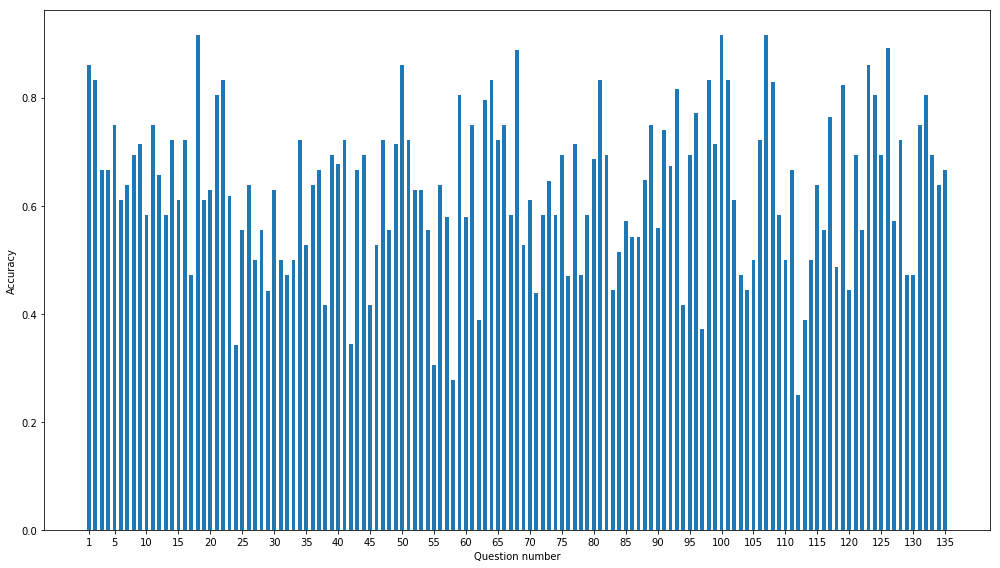

In [36]:
plt.figure(figsize=(14,8))
plt.bar(np.linspace(0,len(accuracy_list)-1,len(accuracy_list)), accuracy_list, width=0.6)
# plt.title("Accuracy for each quesstion")
plt.xlabel("Question number")
plt.ylabel("Accuracy")
plt.xticks([0]+[i for i in range(135) if (i+1)%5==0],[1]+[i+1 for i in range(135) if (i+1)%5==0])
plt.tight_layout()
plt.savefig("../Plotting/images/sem_ques")
plt.show()

In [37]:
for idx in top_5:
    i = df["question_id"].unique()[idx]
    print(i)
    print(df[df["question_id"]==i]["question"].values[0])
    print(df[df["question_id"]==i]["ref_answer"].values[0])
#     print(df[df["question_id"]==i]["grades_round"].values)
    print(df[df["question_id"]==i]["grades_round"].unique())
    print(accuracy_list[idx])
    print("==============================================")

ST_31b
One function of the bess beetle's elytra (the hard, black wing set) is protection. What is another function of the elytra?
The elytra are used to make sounds.
[4 1 3]
0.8611111111111112
MS_50a
Jen was talking on the phone with her Uncle Bill who lives in Canada. When she asked him how the weather was, he said it was nice and warm, about 28 degrees. What unit is Uncle Bill using to report the temperature?
Bill must have been using degrees Celsius if 28 is a warm temperature.
[1 4 2]
0.8888888888888888
VB_12d
Describe the relationship between the length of the string and the number of swings a swinger makes in 15 seconds.
The shorter the string is, the more the string swings in 15 seconds.  The longer the string is, the less the string swings in 15 seconds.
[4 1 3 2]
0.8918918918918919
FN_17a
Paula wants to test a food to see if it contains acid and/or sugar. When Paula added water and yeast to a sample of the food and put the mixture in a warm water bath, the mixture began to fiz

In [39]:
for idx in last_5:
    i = df["question_id"].unique()[idx]
    print(i)
    print(df[df["question_id"]==i]["question"].values[0])
    print(df[df["question_id"]==i]["ref_answer"].values[0])
    print(df[df["question_id"]==i]["grades_round"].values)
    print(df[df["question_id"]==i]["grades_round"].unique())
    print(accuracy_list[idx])
    print("==============================================")

SE_25a
The graph shows temperature data from 2 containers. One container had 100 milliliters of water and the other had 100 milliliters of dry soil. Each container was placed in the sun for 20 minutes and then in the shade for 20 minutes. Which container, A or B, had the dry soil? Explain how the graph helped you decide which container had the dry soil.
A. Dry soil heats more quickly and cools off more quickly than water. The graph shows A heats and cools more quickly than B, so A must be the dry soil.
[3 3 3 3 3 3 3 2 2 3 3 4 2 2 2 3 3 4 3 4 3 2 2 3 3 3 3 3 3 3 2 3 4 3 3 2]
[3 2 4]
0.25
ME_78b
Look at the picture of the circuit to the right. What will happen to the motor if the light bulb burns out?
The motor will continue to run because the motor still has a pathway to the D-cell.
[3 2 2 3 3 3 4 4 2 4 3 3 2 2 3 2 3 2 2 3 3 3 3 2 2 3 2 2 2 3 3 2 3 3 3 3]
[3 2 4]
0.2777777777777778
ME_17e
Denise made a circuit to light a bulb or run a motor. She used a special switch. Below is the sche